In [1]:
import tensorflow as tf
import numpy as np
import sklearn as sk
from sklearn.datasets import make_classification
import scikitplot as skplt
import pandas as pd
import cv2

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt             
import random
from tqdm.notebook import tqdm

# PART I: Pre processing subsys 1 and 2 Dataset.

Num samples found	: 11996
Num videos found	: 60



Displaying four random frames:


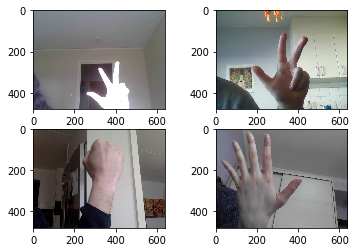

In [64]:
##########################################
# SUBSYSTEM I: Landmark Extraction dataset
##########################################

PATH_DATASET_1    = 'dataset/subsystem_1/Dataset_Subsystem_1.csv'
LANDMARK_OFFSET_I = 5
FRAME_WIDTH       = 640
FRAME_HEIGHT      = 480
TEST_SIZE_I       = 0.20
SHUFFLE           = True

# Importing dataset
dset_1 = pd.read_csv(PATH_DATASET_1, sep=",") # Dataset 2 (csv file)

# Extracting landmarks
Y1features = dset_1.columns[LANDMARK_OFFSET_I:]
Y1         = dset_1[Yfeatures].to_numpy()

# Construct path to every video base on ID + source.
num_samples  = dset_1["ID"].size                          # Num of samples (# videos * frames).
dset_1["ID"] = dset_1["ID"].astype(str)                   # Conver ID columnt to string.
paths_arr    = dset_1[["ID", "source"]].drop_duplicates() # Retrieve ID and source columns.
paths_full   = [os.path.join("dataset", "subsystem_1", "videos", *p) for p in paths_arr.values]

# Compute number of frames per video. (cv2.CAP_PROP_FRAME_COUNT does not work)
idx_frames   = np.append(paths_arr.index.to_numpy(), num_samples) # Contains comulative number of frames.
num_frames   = idx_frames[1:] - idx_frames[0:-1]                  # Contains number of frames of each video. 
num_videos   = len(num_frames)                                    # Expecting 10 videos.

# Print debugging info
print(f"Num samples found\t: {num_samples}")
print(f"Num videos found\t: {num_videos}")

# Creating array of form [number_frames, VideoCapture objects]
caps = [[nf, cv2.VideoCapture(path)] for nf, path in zip(num_frames, paths_full)]

# Allocata space for data array.
X1 = []

for i, cap in tqdm(enumerate(caps), desc="Creating array"):
    frame_count = cap[0]
#     print(frame_count)
    for fc in range(frame_count):
        ret, frame = cap[1].read()
        if ret:
            X1.append(frame.flatten())
            
    cap[1].release()

# Ignoring frames from 711 folder
X1 = X1[0:10747]
Y1 = Y1[0:10747,:]

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = TEST_SIZE_I, shuffle=SHUFFLE)

# Display 4 random frames
print("Displaying four random frames:")
for i in range(1, 5):
    random_frame = random.choice(X1_train).reshape(FRAME_HEIGHT, FRAME_WIDTH, 3)
    im = cv2.cvtColor(random_frame, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,i)
    plt.imshow(im)

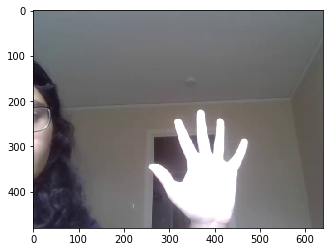

In [66]:
# Use this to show a random frame.
##################################
random_frame = random.choice(X).reshape(FRAME_HEIGHT, FRAME_WIDTH, 3)
plt.imshow(cv2.cvtColor(random_frame, cv2.COLOR_BGR2RGB))

Shape imported data		:(62219, 84)
Expecting 80 landmarks		:80
Expecting 2 columns classes	:2
side
side
The following figure is		:['open' 'dorsal']


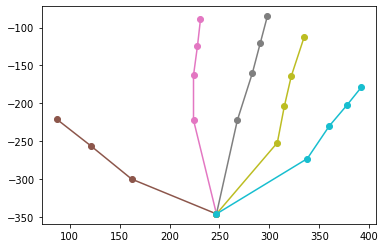

In [71]:
###########################################
# SUBSYSTEM II: Gesture recognition dataset
###########################################
# The following code assumes that: 
# 1: .CSV files contains all hand gestures.
# 2: frame column exits. (This will be handled here).
# 3: 20 landmarks for each side of hand. (40 in total).

# Macros
LANDMARKS_NUM            = 80
LANDMARKS_OFFSET         = 4
CLASS_OFFSET             = 2
PATH_DATASET_2           = 'dataset/subsystem_2/Dataset_subsystem_2.csv'

# Pre processing params
shuffle    = True         # Shuffle data before using.
dropout    = False        # Dropout regularization.
gradcheck  = False        # Gradient checking. 
moredata   = False        # Extend dataset adding modifications of data.
test_size  = 0.10         # Train, test percentage. 


# LOADING DATASET 2
##################################
dset_2 = pd.read_csv(PATH_DATASET_2, sep=",") # Dataset 2 (csv file)

Xfeatures = dset_2.columns[LANDMARKS_OFFSET:]
Yfeatures = dset_2.columns[CLASS_OFFSET:CLASS_OFFSET + 2]

X2 = dset_2[Xfeatures].to_numpy(dtype=np.float32)  # Extracting samples. 
Y2 = dset_2[Yfeatures]                             # Extracing classes.

print(f'Shape imported data\t\t:{dset_2.shape}')
print(f'Expecting {LANDMARKS_NUM} landmarks\t\t:{Xfeatures.shape[0]}')
print(f'Expecting 2 columns classes\t:{Yfeatures.shape[0]}')

# Encoding as [open, first, three_fingers, dorsal, palm]
onehot_encoder = OneHotEncoder(categories='auto')
onehot_encoded = onehot_encoder.fit_transform(Y2).toarray()

# Display random hand gestures.
random_indx = random.choice(range(X2.shape[0]))
random_hand = X2[random_indx].reshape((2, 20, 2))

for side in random_hand:
    print("side")
    root   = side[0]
    thumb  = np.vstack((root, side[1:4]))
    index  = np.vstack((root, side[4:8]))
    middle = np.vstack((root, side[8:12]))
    ring   = np.vstack((root, side[12:16]))
    pinky  = np.vstack((root, side[16:]))

    thumb  = thumb[~np.all(thumb == 0, axis=1)]
    index  = index[~np.all(index == 0, axis=1)]
    middle = middle[~np.all(middle == 0, axis=1)]
    ring   = ring[~np.all(ring == 0, axis=1)]
    pinky  = pinky[~np.all(pinky == 0, axis=1)]

    for finger in [thumb, index, middle, ring, pinky]:
            plt.plot(finger[:,0], -finger[:,1], marker='o')

print(f'The following figure is\t\t:{Y2.to_numpy()[random_indx]}')
plt.show()

# Split data into train and test sets. Shuffe data if param enabled.
X_train, X_test, Y_train, Y_test = train_test_split(X2, onehot_encoded, test_size = test_size, shuffle=shuffle)

In [72]:
##################################
# SUBSYSTEM II: Gesture recognition
##################################

# Random forest Classifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)
clf.fit(X_train,Y_train)
predicted = onehot_encoder.inverse_transform(clf.predict(X_test))
actual    = onehot_encoder.inverse_transform(Y_test)